# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm


from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

import shap

In [17]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [45]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [46]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [47]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [48]:
pca = PCA(0.99)

In [49]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [50]:
X_train_pca.shape

(7352, 179)

In [51]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

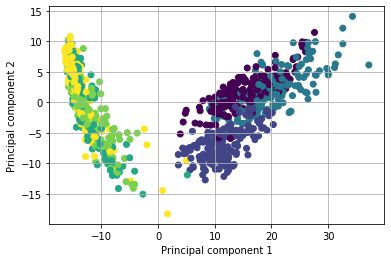

In [52]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

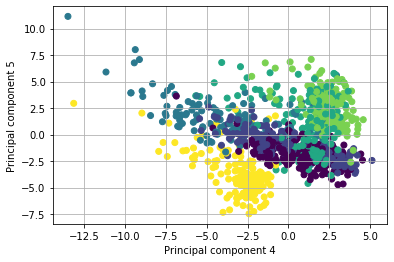

In [53]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [12]:
# Your code here.

In [64]:
%%time
#Градиентный бустинг это хорошо но построим бейзлайн на SMV и оптимизируем сначала его
#Перебирать будем слудующие параметры: kernels, C, безPCA/cPCA

kernels = ['linear', 'rbf']
Cs = [.001,.01, .1 , 1 , 10 , 100 ,1000]
train_dataset = [(X_train, X_test, "WithoutPCA"), (X_train_pca, X_test_pca, "WithPCA")]
accuracy = []
models = []

for kernel in kernels :
    for c in Cs :
        for x_train, x_test, dataset_description in train_dataset :
            
            clf = SVC(C=c, kernel=kernel, random_state = 42)
            clf.fit(x_train, y_train)

            y_test_head = clf.predict(x_test)
            acc = np.mean(y_test_head == y_test)
            
            accuracy.append(acc)
            models.append([clf, dataset_description])
            
            print("accuracy:%s \t dataset:%s \t kernel:%s \t C:%s" % (acc, dataset_description, clf.kernel, clf.C))

accuracy:0.9446895147607737 	 dataset:WithoutPCA 	 kernel:linear 	 C:0.001
accuracy:0.9443501866304717 	 dataset:WithPCA 	 kernel:linear 	 C:0.001
accuracy:0.9524940617577197 	 dataset:WithoutPCA 	 kernel:linear 	 C:0.01
accuracy:0.9450288428910757 	 dataset:WithPCA 	 kernel:linear 	 C:0.01
accuracy:0.9616559212758737 	 dataset:WithoutPCA 	 kernel:linear 	 C:0.1
accuracy:0.9494401085850017 	 dataset:WithPCA 	 kernel:linear 	 C:0.1
accuracy:0.9609772650152698 	 dataset:WithoutPCA 	 kernel:linear 	 C:1
accuracy:0.9501187648456056 	 dataset:WithPCA 	 kernel:linear 	 C:1
accuracy:0.9582626399728538 	 dataset:WithoutPCA 	 kernel:linear 	 C:10
accuracy:0.9518154054971157 	 dataset:WithPCA 	 kernel:linear 	 C:10
accuracy:0.9596199524940617 	 dataset:WithoutPCA 	 kernel:linear 	 C:100
accuracy:0.9507974211062097 	 dataset:WithPCA 	 kernel:linear 	 C:100
accuracy:0.9596199524940617 	 dataset:WithoutPCA 	 kernel:linear 	 C:1000
accuracy:0.9504580929759077 	 dataset:WithPCA 	 kernel:linear 	 C:10

In [67]:
print("Лучшее качество бейзлайна:", np.max(accuracy))
clf, dataset_description =  models[np.argmax(accuracy)]
print("dataset:%s \t kernel:%s \t C:%s" % (dataset_description, clf.kernel, clf.C))

Лучшее качество бейзлайна: 0.9616559212758737
dataset:WithoutPCA 	 kernel:linear 	 C:0.1


In [110]:
#Попробуем пребить бейзлайн с грандиентным бустингом. На этот раз 

num_leaves = [10,31,100,1000]
n_estimators = [100,200,1000]
feature_fractions = [0.3, 0.7, 0.9 , 1]

In [113]:
%%time
accuracy_lgb = []
models_lgb = []
for num_leave in num_leaves :
    for n_estimator in n_estimators :
        for feature_fraction in feature_fractions :
            
            clf = lgb.LGBMClassifier(random_state=42, 
                                     feature_fraction=feature_fraction, 
                                     n_estimators=n_estimator, 
                                     num_leaves=num_leave)
            clf.fit(X_train, y_train)
            
            y_test_head = clf.predict(X_test)
            acc = np.mean(y_test_head == y_test)
            
            accuracy_lgb.append(acc)
            models_lgb.append(clf)
            
            print("accuracy:%s \t feature_fraction:%s \t n_estimators:%s \t num_leaves:%s" % (acc, clf.feature_fraction, clf.n_estimators, clf.num_leaves))

accuracy:0.9433322022395657 	 feature_fraction:0.3 	 n_estimators:100 	 num_leaves:10
accuracy:0.9416355615880556 	 feature_fraction:0.7 	 n_estimators:100 	 num_leaves:10
accuracy:0.9429928741092637 	 feature_fraction:0.9 	 n_estimators:100 	 num_leaves:10
accuracy:0.9423142178486597 	 feature_fraction:1 	 n_estimators:100 	 num_leaves:10
accuracy:0.9477434679334917 	 feature_fraction:0.3 	 n_estimators:200 	 num_leaves:10
accuracy:0.9474041398031897 	 feature_fraction:0.7 	 n_estimators:200 	 num_leaves:10
accuracy:0.9504580929759077 	 feature_fraction:0.9 	 n_estimators:200 	 num_leaves:10
accuracy:0.9497794367153037 	 feature_fraction:1 	 n_estimators:200 	 num_leaves:10
accuracy:0.9521547336274178 	 feature_fraction:0.3 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9514760773668137 	 feature_fraction:0.7 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9518154054971157 	 feature_fraction:0.9 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9518154054971157 	 feature_fraction:1 	 n_es

KeyboardInterrupt: 

In [128]:
print("Лучшее качество градиентного бустинга (читого):", np.max(accuracy_lgb))
clf =  models_lgb[np.argmax(accuracy_lgb)]
print("feature_fraction:%s \t n_estimators:%s \t num_leaves:%s" % (clf.feature_fraction, clf.n_estimators, clf.num_leaves))

Лучшее качество градиентного бустинга (читого): 0.9521547336274178
feature_fraction:0.3 	 n_estimators:1000 	 num_leaves:10


In [130]:
#Теперь попробуем с dart
%%time
num_leaves = [10,31,100]
n_estimators = [100,1000]
feature_fractions = [0.3, 0.7, 0.9 , 1]

for num_leave in tqdm(num_leaves) :
    for n_estimator in n_estimators :
        for feature_fraction in feature_fractions :
            
            clf = lgb.LGBMClassifier(random_state=42, 
                                     boosting_type="dart",
                                     feature_fraction=feature_fraction, 
                                     n_estimators=n_estimator, 
                                     num_leaves=num_leave)
            clf.fit(X_train, y_train)
            
            y_test_head = clf.predict(X_test)
            acc = np.mean(y_test_head == y_test)
            
            accuracy_lgb.append(acc)
            models_lgb.append(clf)
            
            print("accuracy:%s \t feature_fraction:%s \t n_estimators:%s \t num_leaves:%s" % (acc, clf.feature_fraction, clf.n_estimators, clf.num_leaves))

  0%|                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]

accuracy:0.9222938581608415 	 feature_fraction:0.3 	 n_estimators:100 	 num_leaves:10
accuracy:0.9158466236851035 	 feature_fraction:0.7 	 n_estimators:100 	 num_leaves:10
accuracy:0.9189005768578216 	 feature_fraction:0.9 	 n_estimators:100 	 num_leaves:10
accuracy:0.9175432643366135 	 feature_fraction:1 	 n_estimators:100 	 num_leaves:10
accuracy:0.9497794367153037 	 feature_fraction:0.3 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9484221241940957 	 feature_fraction:0.7 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9480827960637936 	 feature_fraction:0.9 	 n_estimators:1000 	 num_leaves:10


 33%|██████████████████████████████████████████████████▋                                                                                                     | 1/3 [11:31<23:03, 691.88s/it]

accuracy:0.9450288428910757 	 feature_fraction:1 	 n_estimators:1000 	 num_leaves:10
accuracy:0.9284017645062775 	 feature_fraction:0.3 	 n_estimators:100 	 num_leaves:31
accuracy:0.9165252799457075 	 feature_fraction:0.7 	 n_estimators:100 	 num_leaves:31
accuracy:0.9151679674244995 	 feature_fraction:0.9 	 n_estimators:100 	 num_leaves:31
accuracy:0.9168646080760094 	 feature_fraction:1 	 n_estimators:100 	 num_leaves:31
accuracy:0.9416355615880556 	 feature_fraction:0.3 	 n_estimators:1000 	 num_leaves:31
accuracy:0.9399389209365456 	 feature_fraction:0.7 	 n_estimators:1000 	 num_leaves:31
accuracy:0.9402782490668476 	 feature_fraction:0.9 	 n_estimators:1000 	 num_leaves:31


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2/3 [1:01:05<22:56, 1376.41s/it]

accuracy:0.9392602646759416 	 feature_fraction:1 	 n_estimators:1000 	 num_leaves:31
accuracy:0.9267051238547676 	 feature_fraction:0.3 	 n_estimators:100 	 num_leaves:100
accuracy:0.9209365456396336 	 feature_fraction:0.7 	 n_estimators:100 	 num_leaves:100
accuracy:0.9168646080760094 	 feature_fraction:0.9 	 n_estimators:100 	 num_leaves:100
accuracy:0.9168646080760094 	 feature_fraction:1 	 n_estimators:100 	 num_leaves:100
accuracy:0.9423142178486597 	 feature_fraction:0.3 	 n_estimators:1000 	 num_leaves:100


KeyboardInterrupt: 

In [253]:
#Топ3 Модели
top3svm_indexies = np.argsort(accuracy)[::-1][:3]
top3lgb_indexies = np.argsort(accuracy_lgb)[::-1][:3]

for indx in top3svm_indexies:
    print("%s  %s %s" % (indx, accuracy[indx], models[indx]))
    
for indx in top3lgb_indexies:
    print("%s %s %s" % (indx, accuracy_lgb[indx], models_lgb[indx]))

4  0.9616559212758737 [SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'WithoutPCA']
6  0.9609772650152698 [SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'WithoutPCA']
12  0.9596199524940617 [SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'WithoutPCA']
8 0.9521547336274178 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.

Получается что SVM лучше справляется с этой задачей. Сравним 6 лучших моделей:

In [228]:
best6_models = [
    SVC(random_state=42,C=0.1, kernel='linear',probability=True),
    SVC(random_state=42,C=1, kernel='linear',probability=True),
    SVC(random_state=42,C=1000, kernel='linear',probability=True)    
]
best6_models[0].fit(X_train, y_train)
best6_models[1].fit(X_train, y_train)
best6_models[2].fit(X_train, y_train)

# best6_models += [models[index][0] for index in top3svm_indexies]
best6_models += [models_lgb[index] for index in top3lgb_indexies]

In [229]:
enc = OneHotEncoder()
enc.fit(y_test.reshape(-1, 1))
y_test_one_hot = enc.transform(y_test.reshape(-1, 1)).toarray()

fpr_betsmodel = dict()
tpr_betsmodel = dict()
roc_auc_betsmodel = dict()

for clf_index, best_clf in tqdm(enumerate(best6_models)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_head = best_clf.predict_proba(X_test)

    enc = OneHotEncoder()
    enc.fit(y_test.reshape(-1, 1))
    y_test_one_hot = enc.transform(y_test.reshape(-1, 1)).toarray()

    for class_index in range(1, np.unique(y_test).shape[0] + 1) :
        fpr[class_index], tpr[class_index], _ = roc_curve(y_test_one_hot[:,class_index-1], y_test_head[:,class_index-1])
        roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
        
    fpr_betsmodel[clf_index], tpr_betsmodel[clf_index], _ = roc_curve(y_test_one_hot.ravel(), y_test_head.ravel())
    roc_auc_betsmodel[clf_index] = auc(fpr_betsmodel[clf_index], tpr_betsmodel[clf_index])


0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:02,  1.36s/it]
3it [00:03,  1.30s/it]
4it [00:03,  1.04it/s]
5it [00:04,  1.40it/s]
6it [00:04,  1.41it/s]


0.9976891144065458
0.998011539459302
0.9980535208085751
0.9982846139736636
0.9981773922719545
0.9981691940490572


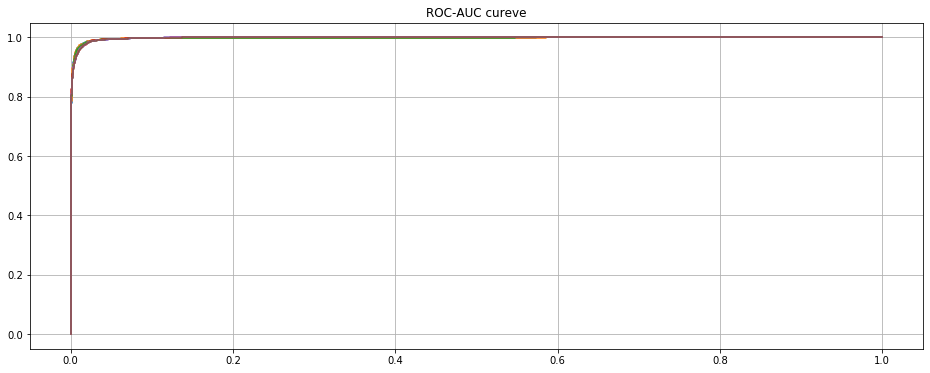

In [234]:
for key in roc_auc_betsmodel:
    print(roc_auc_betsmodel[key])

plt.figure(figsize=(16,6))
plt.grid(True)
plt.title("ROC-AUC curve")
for fpr_key,tpr_key in zip(fpr_betsmodel, tpr_betsmodel):
    plt.plot(fpr_betsmodel[fpr_key], tpr_betsmodel[tpr_key])    
plt.show()


Небольшой вывод: для начала была поставлена задача получить необходимую точность без градиентного бустинга, для этого было решено использовать SVM с PCA/без PCA. Во-первых, получилось, что SVM выдает достаточно хорошую accuracy, а PCA не совсем подходит для обучения. Также я попробовала перебрать параметры для градиентного бустинга, результат получился хорошим, но с точки зрения метрики accuracy SVM все же показал себя лучше. Лучшая точность модели полученная мной: 0.9616559212758737 

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

Используем Voting Classifire, чтобы посмотреть, какой результат даст ансамбль из 6 лучших моделей. Переберем варианты soft и hard голосования.


In [254]:
#Попробуем софт и хард голосование и посмотрим, какие получатся результаты
votingtypes = ["soft", "hard"]
working_estimators_indxs = [
    [1,2,3],
    [1,4],
    [1,2,3,4,5,6]
]


for voiting in votingtypes :
    for working_estimators_indx in working_estimators_indxs :
        best6models = [
            ("svm_C01_linear", SVC(random_state=42,C=0.1, kernel='linear',probability=True)),
            ("svm_C1_linear", SVC(random_state=42,C=1, kernel='linear',probability=True)),
            ("svm_C1000_linear", SVC(random_state=42,C=1000, kernel='linear',probability=True)),
            ("lgbm_ff03_nest1000_nleavs10", lgb.LGBMClassifier(random_state=42, feature_fraction=0.3, n_estimators=1000, num_leaves=10)),
            ("lgbm_ff09_nest1000_nleavs10", lgb.LGBMClassifier(random_state=42, feature_fraction=0.9, n_estimators=1000, num_leaves=10)),
            ("lgbm_ff1_nest1000_nleavs10", lgb.LGBMClassifier(random_state=42, feature_fraction=0.1, n_estimators=1000, num_leaves=10))
        ]
        estimators = [best6models[indx-1] for indx in working_estimators_indx]

        voiting_clf = VotingClassifier(
            estimators,
            voting=voiting,
        )

        voiting_clf.fit(X_train, y_train)

        y_test_head = voiting_clf.predict(X_test)
        acc = np.mean(y_test_head == y_test)
        print("Accuracy of voiting classifire with predict: %s (%s, train on %s)" % (acc, voiting, working_estimators_indx))

Accuracy of voiting classifire with hard predict: 0.9619952494061758 (soft, train on [1, 2, 3])
Accuracy of voiting classifire with hard predict: 0.9592806243637597 (soft, train on [1, 4])
Accuracy of voiting classifire with hard predict: 0.9630132337970818 (soft, train on [1, 2, 3, 4, 5, 6])
Accuracy of voiting classifire with hard predict: 0.9626739056667798 (hard, train on [1, 2, 3])
Accuracy of voiting classifire with hard predict: 0.9562266711910418 (hard, train on [1, 4])
Accuracy of voiting classifire with hard predict: 0.9602986087546658 (hard, train on [1, 2, 3, 4, 5, 6])


Вывод: лучше всего показало себя ансамбль из 6 лучших моделей (3svm 3gb) с soft голосованием. Лучшая точность одинокой модели - 0.9616559212758737. Лучшая точность ансамбля - 0.9630132337970818 

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [18]:
# Your code here.
bestlgb_models = [
    lgb.LGBMClassifier(random_state=42, feature_fraction=0.3, n_estimators=1000, num_leaves=10),
    lgb.LGBMClassifier(random_state=42, feature_fraction=0.9, n_estimators=1000, num_leaves=10),
    lgb.LGBMClassifier(random_state=42, feature_fraction=0.1, n_estimators=1000, num_leaves=10)
]
for clf in bestlgb_models :
    clf.fit(X_train, y_train)

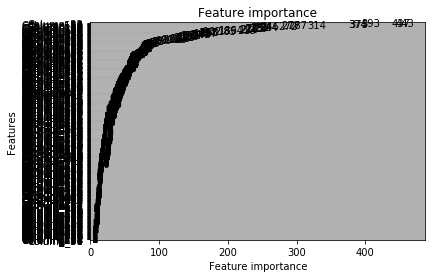

In [6]:
lgb.plot_importance(bestlgb_models[0])

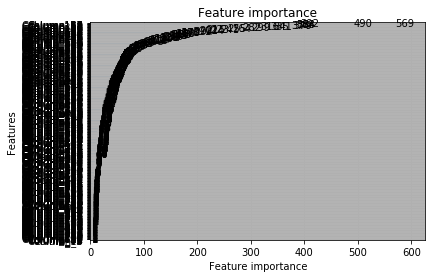

In [19]:
lgb.plot_importance(bestlgb_models[1])

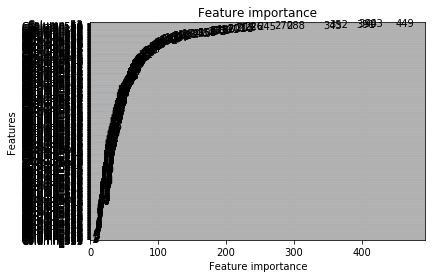

In [20]:
lgb.plot_importance(bestlgb_models[2])

In [19]:
shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


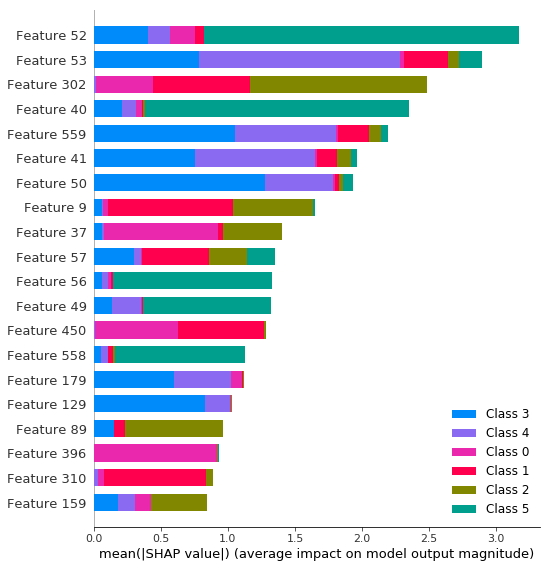

In [41]:
explainer = shap.TreeExplainer(bestlgb_models[0])
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


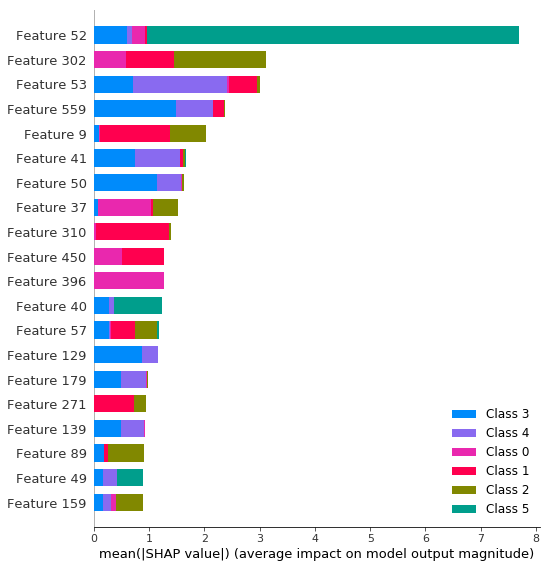

In [42]:
explainer = shap.TreeExplainer(bestlgb_models[1])
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


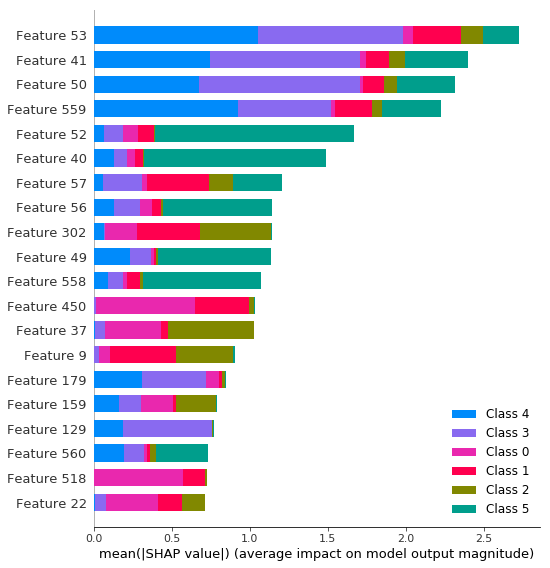

In [40]:
explainer = shap.TreeExplainer(bestlgb_models[2])
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Вывод: для первой модели из анализируемых топ-5 фич, влияющих на результат в целом: 52, 53, 302, 40, 559. Второй: 52, 302, 53, 559, 9. Третьей: 53, 41, 50, 559, 52. Как и ожидалось, поскольку модели аналогичные и у них одинаковый  random state, в каждой модели наибольший вклад оказывают примерно одни и те же фичи. Самые важные фичи: 52 и 53. Интересный график у второй модели. Если для моделей 1 и 3 важность фич снижается постепенно, то для второй модели самой важной фичей является 52 и остальные следуют за ней с очень большим отрывым. С помощью shap важность фич интерпретировать гораздо удобнее, чем с помощью встроенных функций.